# Visualization for Layerwise Attention Tracing

This file contains our visualization for layerwise attention tracing. 

The method implementation is not in this file. Please refer to *model.py* to take a look. In this file, we will providing two examples, one for SST dataset, one from SEND dataset to illustrate the attention tracing through layers. The visualization method could 
be applied to other transformer based model as well. 

All the attention visualization function is in the *attention_util*, feel free to modify. **Please cite our work before using them.**


## Let us import all the libraries needed

In [1]:
%matplotlib inline
import random
import torch
import pickle
from attention_util import *
import torch.nn.functional as F

## First, let us loaded all the pre-computed attention scores to our memory. 

You can import yours as long as the format remains the same. Our format is a standard way of saving calculated attention scores.

`id_tf_attns` = dict({"sentend_id" : self_attention_score_matrix})
`self_attention_score_matrix` = (head, layer, n_token, n_token)

`id_ctx_attns_sst` = dict({"sentend_id" : local_attention_score_matrix})
`local_attention_score_matrix` = (1, n_token)

`id_sentence` and `id_labels_test_sst` is nothing but the mapping between sentence id and the corresponding content.

In [ ]:
SAVE_DIR = "../nlap/"
data_folder = "../../../Stanford-Sentiment-Treebank/"

In [2]:
#######################################################################
#
# Visualization for SST dataset
#
#######################################################################
# load the transformer attention to memory for all samples
id_tf_attns = pickle.load( open(SAVE_DIR + "/id_tf_attns_sst.p", "rb" ) )
id_ctx_attns = pickle.load( open(SAVE_DIR + "/id_ctx_attns_sst.p", "rb" ) )
all_sentence = pickle.load( open( data_folder + "id_sentence.p", "rb" ) )
id_labels = pickle.load( open(SAVE_DIR + "/id_labels_test_sst.p", "rb" ) )

## Select an example from SST to visualize

We are restrict the sentence length to be `10` considering that might just fit our screen size.

You can change to other length.

In [3]:
# get sentences with length = 10 (this is easier to make good visualizations)
sentence_in_10 = []
for seq in id_tf_attns.keys():
    tf_attns = torch.FloatTensor(id_tf_attns[seq])
    sentence = all_sentence[seq]
    # input params
    tokens = tf_attns.shape[2]
    # let us skip visualization long sequence
    if tokens == 10:
        sentence_in_10.append(seq)

In [4]:
#######################################################################
#
# Rerun this block to randomly select an example to visualize
#
#######################################################################
# seq_rand = random.choice(sentence_in_10)
seq_rand = 489
# A good example is sentence #489, you can try this.
sentence = all_sentence[seq_rand]
print("Visualizing this sentence #" + str(seq_rand) + " :")
print(sentence)
tf_attns = torch.FloatTensor(id_tf_attns[seq_rand])
ctx_attns = torch.FloatTensor(id_ctx_attns[seq_rand])
labels = id_labels[seq_rand]
print("True Label: " + labels[0].strip("$") + "; Predicted Label: " + labels[1].strip("$") )

Visualizing this sentence #489 :
['an', 'impressive', 'if', 'flawed', 'effort', 'that', 'indicates', 'real', 'talent', '.']
True Label: +; Predicted Label: +


## Visualize Attention Distribution in Each Head (Not Accumulated)

This follows the visualization method that was previously proposed (and probably the commomly used method) to visualze attention scores within each head. Note that the tokens in each head is not directly mapped to the original input tokens! We think it is important to call-out this assumption (previous papers usually assume the tokens in each head maps to the original tokens, which is not true as they are transformed within self-attention layers).

<IPython.core.display.Javascript object>


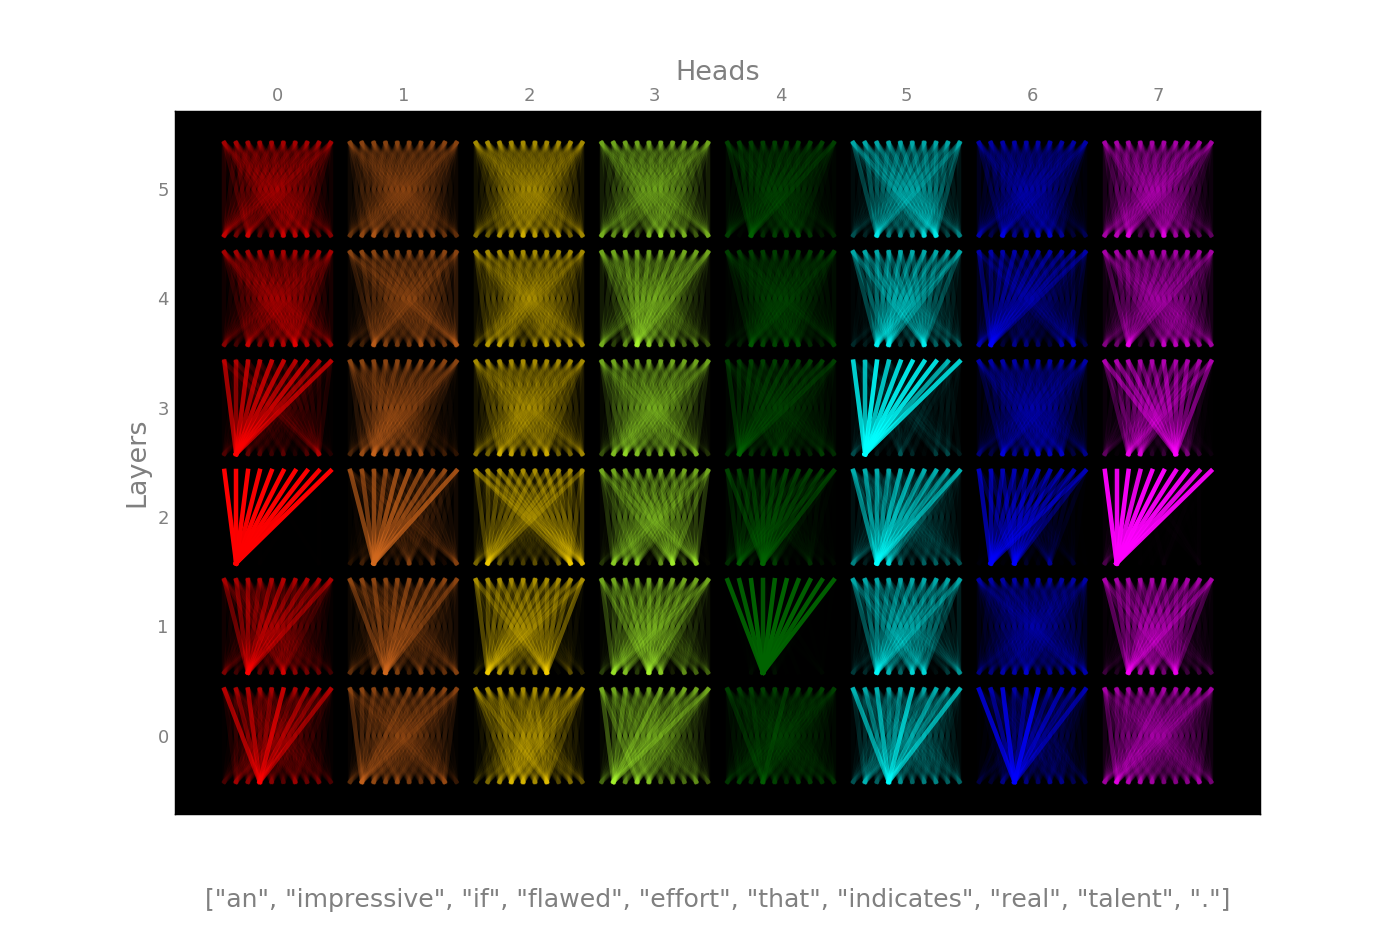

In [5]:
'''
This is the visualization for attentions on each heads on each layer separately.
'''
%matplotlib notebook
head_attn_viz_func(tf_attns, sentence, seq_rand)

## Visualize of the Layerwise Attention Tracing (Accumulated Attention)

It visualize the method we are proposing with the example sentence. You can play around with different parameters to see which one you want to use. We also provide different reduce function so that you can try to make the opacity of each points different by using different reduce function.

Each line is mapped to the calculated attention score. The opacity is mapped to the magnitude of the attention score.

Each dot it mapped to a token (i.e. position). The opacity is mapped to the accumulated attention in that position.

Raw attention score:
tensor([0.4422, 1.0257, 0.7158, 2.1202, 0.8225, 0.5372, 0.7545, 0.5731, 0.5894,
        0.4195])


<IPython.core.display.Javascript object>


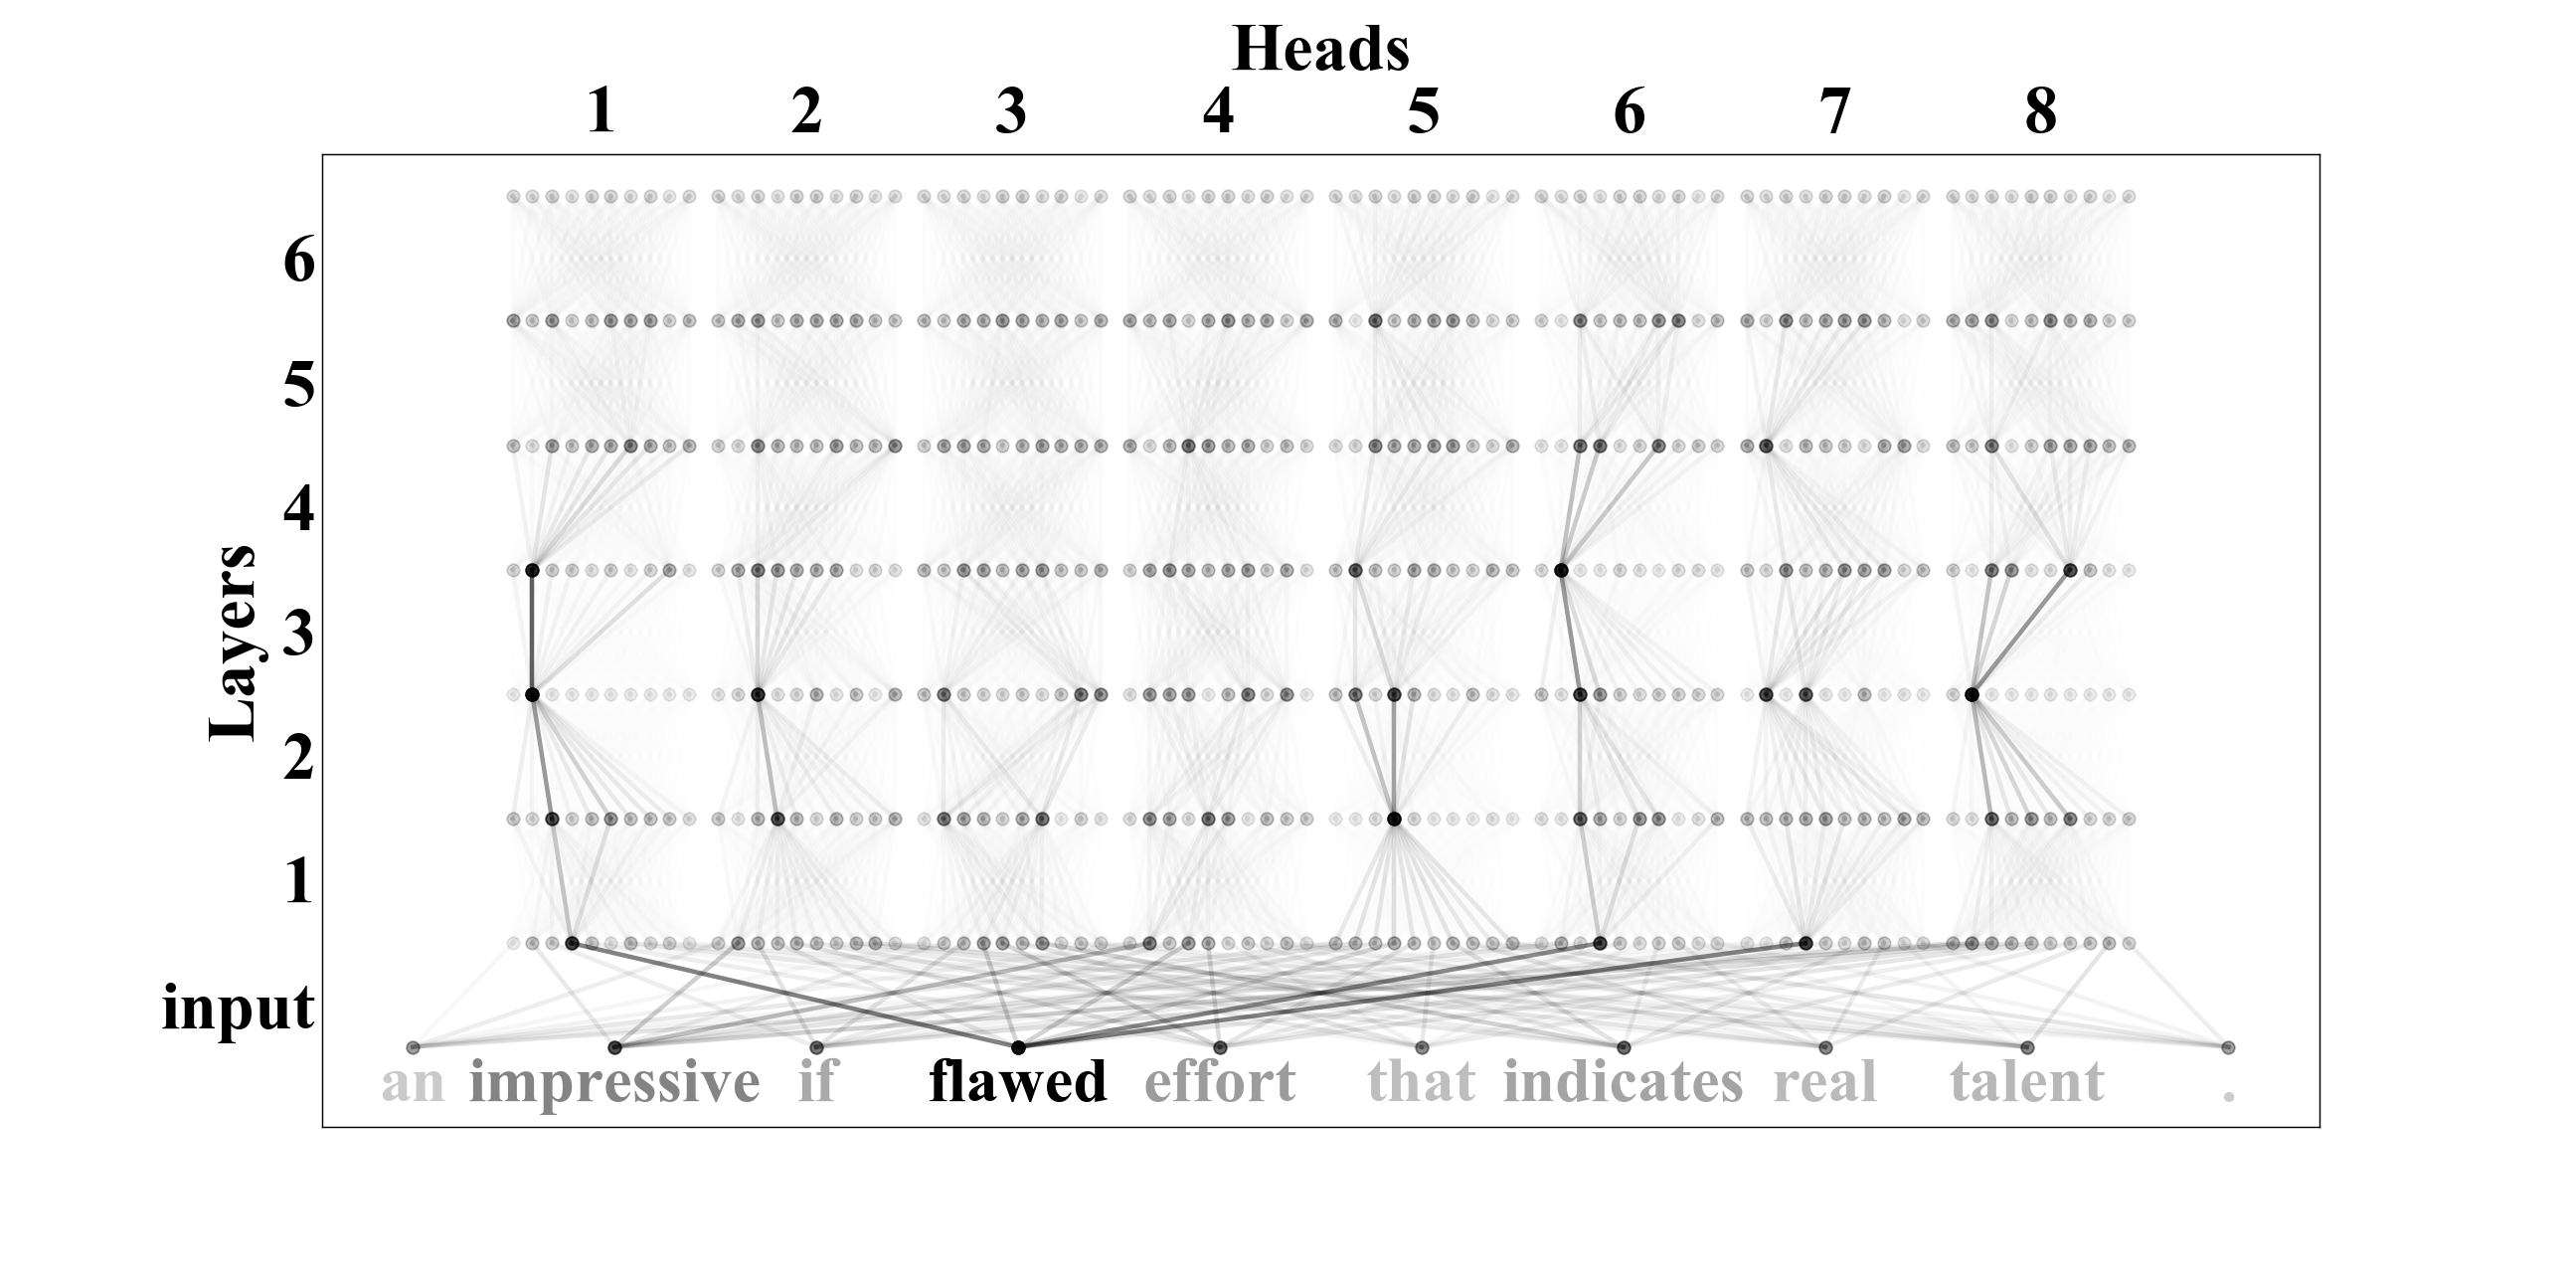

In [6]:
'''
This is the visualization for accumulative attentions.
'''
%matplotlib notebook
trace_attn_viz_func(tf_attns, ctx_attns, sentence, seq_rand, reduce="min_max", view="customize")

## Try with SEND dataset

Please refer to previous steps for explainations. This is repeating the same steps but on SEND dataset.

In [7]:
#######################################################################
#
# Visualization for SEND dataset
#
#######################################################################
# load the transformer attention to memory for all samples
seq_label = pickle.load( open(SAVE_DIR + "/seq_labels_test_send.p", "rb") )
seq_sentence = pickle.load( open(SAVE_DIR + "/seq_sentences_test_send.p", "rb") )
seq_tf_attns = pickle.load( open(SAVE_DIR + "/seq_tf_attns_test_send.p", "rb") )
seq_ctx_attns = pickle.load( open(SAVE_DIR + "/seq_ctx_attns_test_send.p", "rb") )
seq_ccc = pickle.load( open(SAVE_DIR + "/seq_ccc_test_send.p", "rb") )

In [8]:
#######################################################################
#
# Rerun this block to randomly select an example to visualize
#
#######################################################################
ENFORECE_POSTIVE = False # False meaning to look at only positive cases

seqs = [k for k in seq_ccc.keys()][:20] # consider top 20 ccc only, and randomly choose 1 video to look at
found = False
while not found:
    seq_rand = random.choice(seqs)
    # select sentence
    sentence = seq_sentence[seq_rand]
    sentence_index = [i for i in range(len(sentence))]
    sentence_index_rand = random.choice(sentence_index)
    select_sentence = sentence[sentence_index_rand]
    if len(select_sentence) >= 5 and len(select_sentence) <= 10:
        if ENFORECE_POSTIVE:
            if seq_label[seq_rand][sentence_index_rand][0] >= 0.5 and seq_label[seq_rand][sentence_index_rand][1] >= 0.5:
                found = True
        else:
            if seq_label[seq_rand][sentence_index_rand][0] <= -0.5 and seq_label[seq_rand][sentence_index_rand][1] <= -0.5:
                found = True        
print("Found a qualified sentence from video: " + seq_rand + ", ccc: " + str(seq_ccc[seq_rand]) + ".")
print(select_sentence)
actual_r = seq_label[seq_rand][sentence_index_rand][0]
pred_r = seq_label[seq_rand][sentence_index_rand][1]
print("True Rating: " + str(actual_r) + "; Predicted Rating: " + str(pred_r))

# Get all the weights
tf_attns = torch.FloatTensor(seq_tf_attns[seq_rand][sentence_index_rand])
ctx_attns = torch.FloatTensor(seq_ctx_attns[seq_rand][sentence_index_rand])

Found a qualified sentence from video: 112_1, ccc: 0.8806223976140499.
['sort', 'of', 'within', 'the', 'casing', 'of', 'the', 'event', 'i', 'remember']
True Rating: -0.5862633585929871; Predicted Rating: -0.515251100063324


<IPython.core.display.Javascript object>


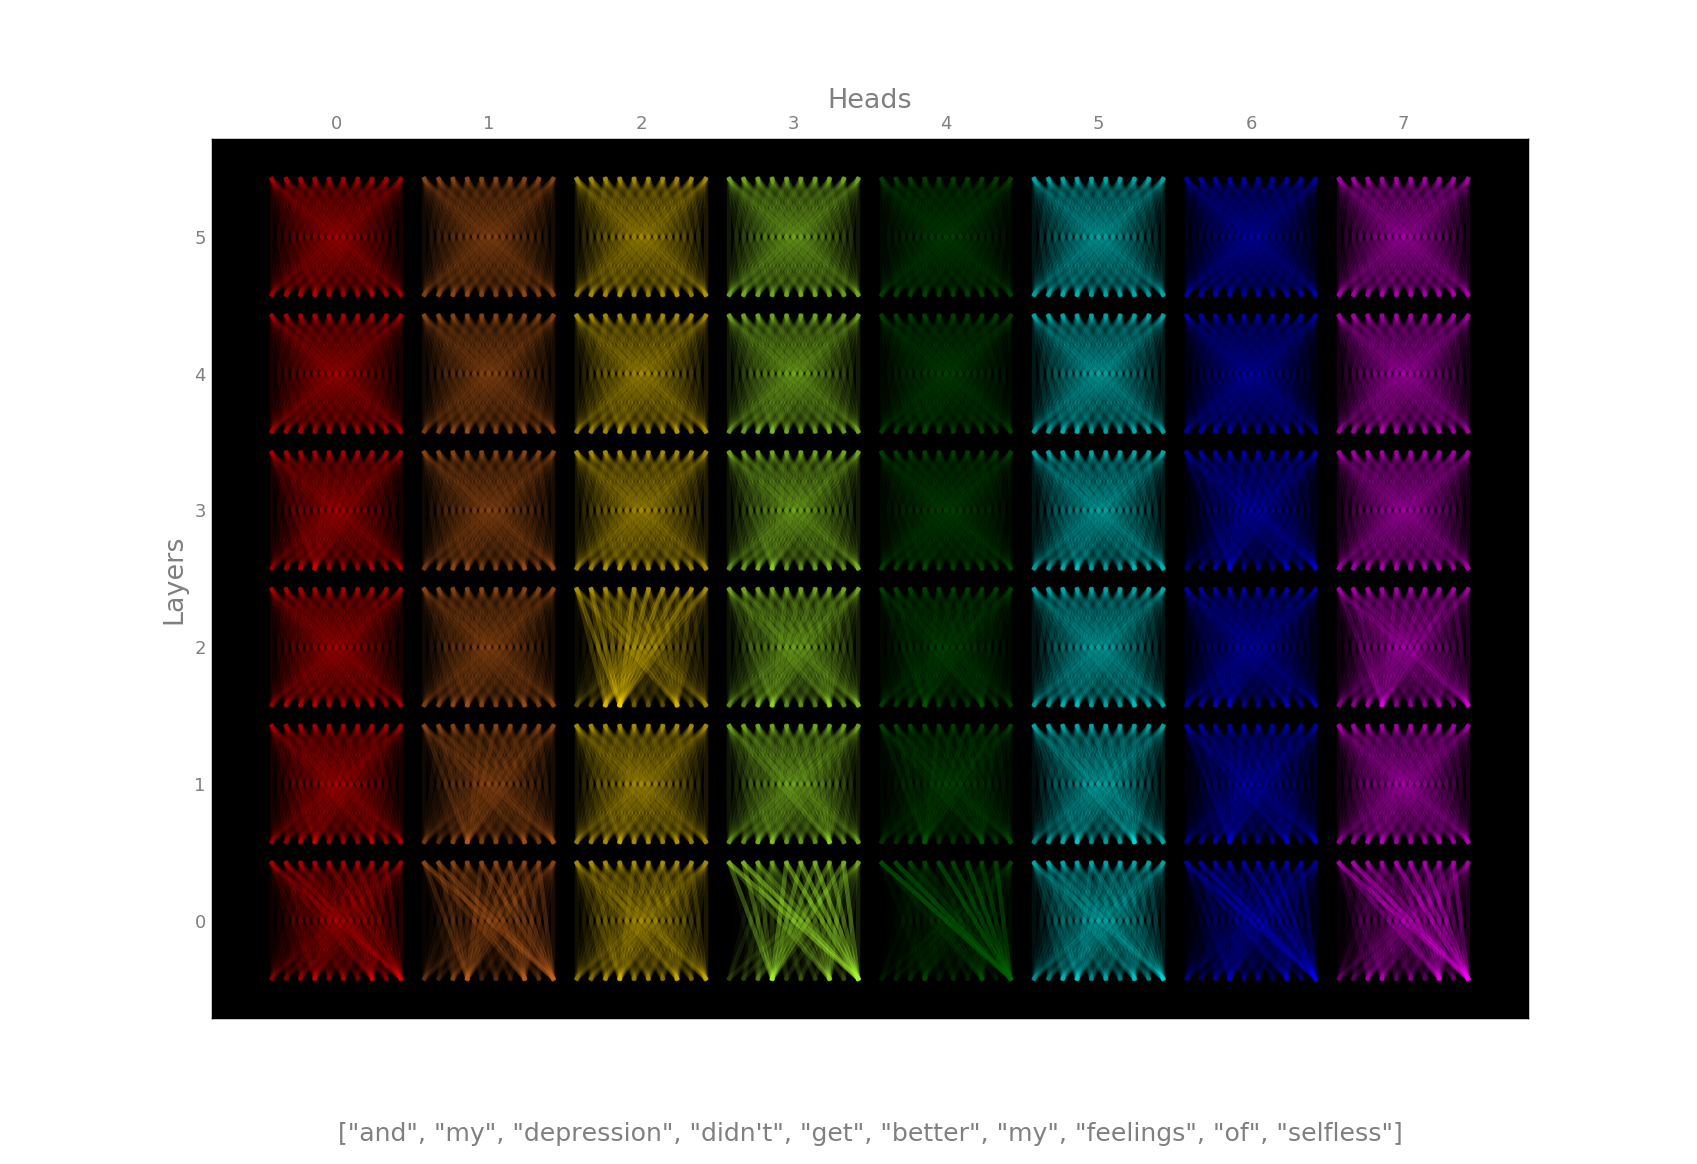

In [81]:
'''
This is the visualization for attentions on each heads on each layer separately.
'''
%matplotlib notebook
head_attn_viz_func(tf_attns, select_sentence, seq_rand)

Raw attention score:
tensor([0.9874, 0.5850, 0.7347, 0.5617, 1.3994, 0.5850, 0.5617, 1.1010, 0.4031,
        1.0808])


<IPython.core.display.Javascript object>


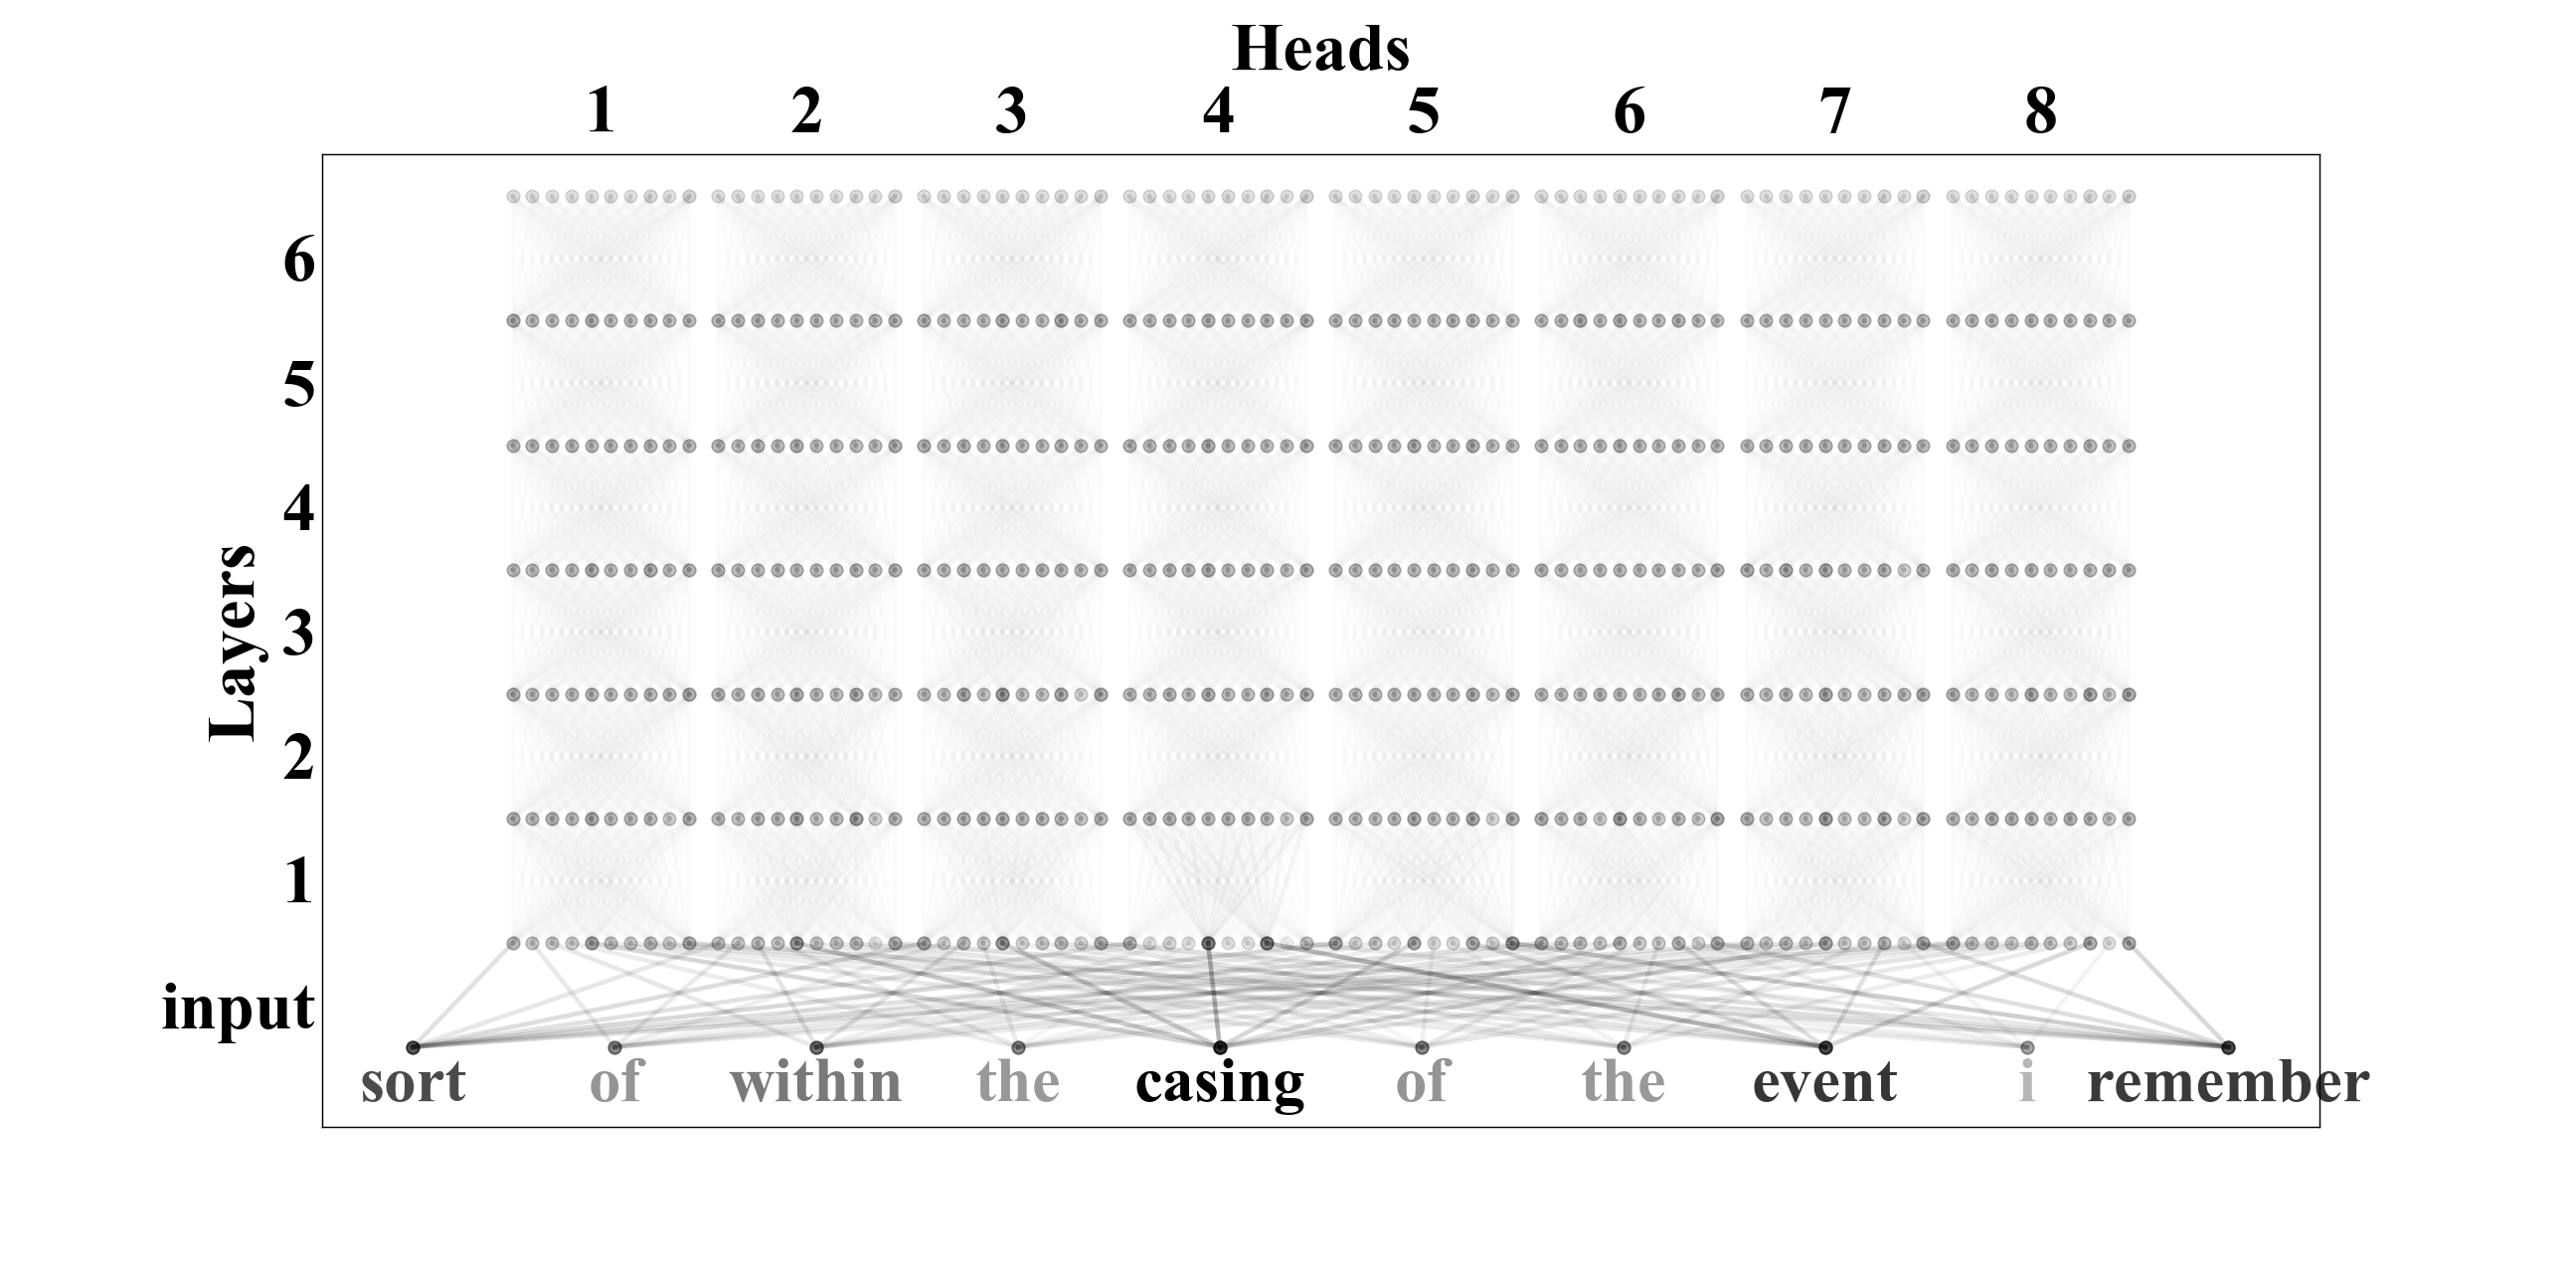

In [9]:
'''
This is the visualization for accumulative attentions.
'''
%matplotlib notebook
trace_attn_viz_func(tf_attns, ctx_attns, select_sentence, seq_rand, reduce="min_max", view="customize")